In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from scipy.signal import medfilt
from astropy import units as uni
from tqdm import tqdm_notebook
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from lightkurve.lightcurve import LightCurve as LC

sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
import stella

In [40]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula = LinearSegmentedColormap.from_list('parula', cm_data)

parula_colors = []
cmap = cm.get_cmap(parula, 2)
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    parula_colors.append(matplotlib.colors.rgb2hex(rgb))
parula_colors = np.array(parula_colors)

In [3]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, 13)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

colormap='inferno'
cmap = cm.get_cmap(colormap, 13)
acolors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    acolors.append(matplotlib.colors.rgb2hex(rgb))
acolors = np.array(acolors)

smallc = colors[1]
largec = colors[8]

smallca = acolors[5]
largeca = acolors[10]

In [4]:
data_dir = '/Users/arcticfox/Documents/flares/youngstar_pred/'

data = np.load(os.path.join(data_dir, 'pred_light_curves.npy'), allow_pickle=True)
TIME = data[0]#[0:200]
FLUX = data[1]#[0:200]
ERR = data[2]#[0:200]

QUAL = np.load(os.path.join(data_dir, 'qual.npy'), allow_pickle=True)

CATALOG = Table.read(os.path.join(data_dir, 'total_table.txt'),
                    format='ascii')

PREDS = np.load(os.path.join(data_dir, 'average_predictions.npy'),
                allow_pickle=True)
TICS = np.load(os.path.join(data_dir, 'tics.npy'), allow_pickle=True)

W0622 12:31:26.730983 4572726720 logger.py:204] OverflowError converting to FloatType in column YA_prob, possibly resulting in degraded precision.


In [5]:
QTIME, QFLUX, QERR, QPRED = [], [] , [], []

for i in tqdm_notebook(range(len(TICS))):
#    init_per = fts.LS_results['period_days'].data[i]
    mask = QUAL[i]+0.0#np.zeros(len(FLUX[i]))

    diff_time = np.diff(TIME[i])
    orbit = np.where(diff_time >= np.nanmedian(diff_time)+12*np.nanstd(diff_time))
    orbit = orbit[0][0]
    
   # real_high = np.where(FLUX[i] > 2.0)[0]
    
    mask[0:500] = 1
    mask[orbit:orbit+800]=1
    mask[len(FLUX[i])-50:] = 1
    
  #  mask[real_high] = 1

    q = (mask == 0)
    
   # if np.nanstd(FLUX[i][q]) > 0.1:
   #     mask[orbit:orbit+500] = 1
        
   # q = ((mask == 0) | (mask == 512))

    lk = LC(time=TIME[i][q], flux=FLUX[i][q], 
            flux_err=ERR[i][q])
    
    QTIME.append(lk.time)
    QFLUX.append(lk.flux)
    QERR.append(np.ones(len(lk.flux)))
    QPRED.append(PREDS[i][q])
    
QTIME = np.array(QTIME)
QFLUX = np.array(QFLUX)
QERR = np.array(QERR)
QPRED = np.array(QPRED)

In [6]:
TICS = np.array([int(i) for i in TICS])

In [8]:
np.save(os.path.join(data_dir, 'qflagged_data.npy'), [TICS,
                                                      QTIME,
                                                      QFLUX,
                                                      QERR,
                                                      QPRED])

## Identifies flares

In [42]:
%load_ext autoreload
%autoreload 2
import stella

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
stella.__path__

['/Users/arcticfox/Documents/GitHub/stella/stella']

In [44]:
inds = np.arange(0, len(TICS),1,dtype=int)
ff = stella.FitFlares(TICS[inds], 
                      QTIME[inds], 
                      QFLUX[inds], 
                      QERR[inds], 
                      QPRED[inds])

In [45]:
ff.identify_flare_peaks()

Finding & Fitting Flares:   1%|          | 46/5112 [00:02<05:32, 15.22it/s]/Users/arcticfox/Documents/GitHub/stella/stella/mark_flares.py:227: RuntimeWarning: divide by zero encountered in true_divide
  detrended = subf/func(subt)
//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/arcticfox/Documents/GitHub/stella/stella/mark_flares.py:231: RuntimeWarning: divide by zero encountered in true_divide
  detrend_with_flare = subf/func1(subt)
Finding & Fitting Flares:  10%|█         | 528/5112 [00:18<02:10, 35.00it/s]//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
Finding & Fitting Flares: 100%|██████████| 5112/5112 [03:12<00:00, 26.53it/s]


In [46]:
ff.flare_table

Target_ID,tpeak,amp,dur_min,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
81003.0,1600.366478577508,0.008841380402856834,41.05366210888219,0.0001,0.008317664524221856,0.9718687534332275
81003.0,1600.4095349925308,0.0057558035006106375,41.03508360808016,0.0001,0.00753906796265501,0.9719749987125397
81003.0,1600.6900961070894,0.007858830781344826,40.0574224749095,0.0001,0.01,0.9954666495323181
81003.0,1600.7900980720426,0.005707504893687427,40.037907253602086,0.0001,0.008387620491074721,0.8532602190971375
81003.0,1601.063714510881,0.007221463078291601,42.052626571745286,0.0001,0.01,0.9718460142612457
81003.0,1601.2109395697214,0.005719892627709999,39.043561638120316,0.0001,0.01,0.9312423467636108
81003.0,1601.4887226394605,0.006030020445216777,39.045367612892086,0.0001,0.01,0.9524803757667542
81003.0,1601.5331679232243,0.009599933938145002,39.070323553355806,0.0001,0.01,0.9989019632339478
81003.0,1601.6290030589037,0.005132006267399576,39.026870004625856,0.0001,0.006258394985321605,0.8147562444210052


In [36]:
ff.flare_table = ff.flare_table[ff.flare_table['amp']>=0.005]

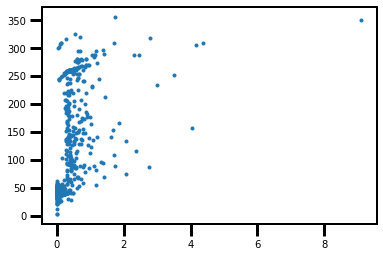

In [38]:
%matplotlib inline
plt.plot(ff.flare_table['amp'], ff.flare_table['dur_min'], '.')

## Maps phases

In [123]:
fts = stella.MeasureProt(TICS, QTIME, QFLUX, QERR)
#fts.run_LS()

In [ ]:
fts.LS_results.write(os.path.join(data_dir, 'basic_LS_table.txt'), format='ascii')

In [ ]:
#array([  7785194, 144126052, 152505948, 165909066, 179315999, 232970271,
#       261335869, 295317497, 349055504, 404484288])
fts.LS_results[fts.LS_results['Target_ID']==373432787]

In [ ]:
fts.phase_lightcurve()

In [ ]:
np.save(os.path.join(data_dir, 'phases.npy'), fts.phases)

## Looking at flares over entire light curve for each star

In [124]:
fts.LS_results = Table.read(os.path.join(data_dir, 'basic_LS_table.txt'), format='ascii')

In [125]:
tot_time = np.zeros(len(fts.LS_results))
n_small = np.zeros(len(fts.LS_results))
n_large = np.zeros(len(fts.LS_results))
weighted_rate = np.zeros(len(fts.LS_results))

for i in range(len(fts.LS_results)):
    tic = fts.LS_results['Target_ID'].data[i]
    inds = np.where(TICS == tic)[0]
    tt = 0
    for n in inds:
        ttime = len(QTIME[n]) * 2 * uni.min
        ttime = ttime.to(uni.day)
        tt += ttime.value
    tot_time[i] = tt
    
    flare_amps = ff.flare_table[ff.flare_table['Target_ID']==tic]#['amp'].data
    #flare_prob = ff.flare_table[ff.flare_table['Target_ID']==tic]['prob'].data
    if len(flare_prob) > 0:
        weighted_rate[i] = np.nansum(flare_prob)
        
    if len(flare_amps[flare_amps['amp'] < 0.05])/tt < 1.01:
        n_small[i] = len(flare_amps[flare_amps['amp'] < 0.05]['amp'])
        weighted_rate[i] = np.nansum(flare_amps[flare_amps['amp'] < 0.05]['prob'])
        
    if len(flare_amps[flare_amps['amp'] > 0.05])/tt < 1.01:
        n_large[i] = len(flare_amps[flare_amps['amp'] >= 0.05]['amp'])
        weighted_rate[i] = np.nansum(flare_amps[flare_amps['amp'] >= 0.05]['prob'])
        
fts.LS_results.add_column(Column(tot_time, 'total_observed_time'))
fts.LS_results.add_column(Column(n_small, 'Nflares_small'))
fts.LS_results.add_column(Column(n_large, 'Nflares_large'))
fts.LS_results.add_column(Column(weighted_rate/tot_time, 'weighted_rate'))

In [126]:
maxflare = np.zeros(len(fts.LS_results))
maxflareE = np.zeros(len(fts.LS_results))
    
for i, tic in enumerate(fts.LS_results['Target_ID']):
    flares = np.where(ff.flare_table['Target_ID'] == float(tic))[0]
    try:
        maxflare[i] = np.nanmax(ff.flare_table['amp'].data[flares])
    except:
        pass

fts.LS_results.add_column(Column(maxflare, 'max_amp'))

## Reads in table for ages

In [127]:
names = np.loadtxt('/Users/arcticfox/Documents/youngStars/group_age.txt', usecols=(0,),
                  dtype='U55')
ages = np.loadtxt('/Users/arcticfox/Documents/youngStars/group_age.txt', usecols=(1,))
ymg_dict = {}
for i in range(len(ages)):
    ymg_dict[names[i]] = ages[i]

In [128]:
tic_tab = Table.read(os.path.join(data_dir, 'test.txt'), format='ascii')

In [129]:
ymg_age, ymg = np.zeros(len(fts.LS_results)), np.zeros(len(fts.LS_results), dtype='U10') 
teffs = np.zeros(len(fts.LS_results))
tmag = np.zeros(len(fts.LS_results))
gaia_rp, gaia_bp = np.zeros(len(fts.LS_results)), np.zeros(len(fts.LS_results))
for i in range(len(fts.LS_results['Target_ID'])):
    tic = fts.LS_results['Target_ID'].data[i]
    ind = np.where(CATALOG['TIC']==tic)[0]
    ind_new = np.where(tic_tab['Target_ID']==tic)[0]
    if len(ind) >= 1:
        ymg_age[i] = ymg_dict[CATALOG['Best_hyp'].data[ind][0]]
        ymg[i] = CATALOG['Best_hyp'].data[ind][0]
        teffs[i] = tic_tab['TIC_Teff'].data[ind_new][0]
        tmag[i] = tic_tab['Tmag'].data[ind_new][0]
        gaia_rp[i] = tic_tab['Gaia_Rp'].data[ind_new][0]
        gaia_bp[i] = tic_tab['Gaia_Bp'].data[ind_new][0]
        if ymg[i] == 'FIELD':
            ymg[i] = 'None'
            ymg_age[i] = 0
            teffs[i] = 0
    else:
        ymg_age[i] = 0
        ymg[i] = 'None'
        teffs[i] = 0

## Adds age columns

In [130]:
fts.LS_results.add_column(Column(ymg_age, 'YMG_age'))
fts.LS_results.add_column(Column(ymg, 'YMG'))
fts.LS_results.add_column(Column(teffs, 'teff_val'))
fts.LS_results.add_column(Column(tmag, 'Tmag'))
fts.LS_results.add_column(Column(gaia_rp,'Bp'))
fts.LS_results.add_column(Column(gaia_bp,'Rp'))

In [134]:
temptable = Table.read(os.path.join(data_dir, 'new_master_rot_table.tab'), 
                   format='ascii')
for colname in temptable.colnames:
    if colname not in fts.LS_results.colnames:
        fts.LS_results.add_column(Column(temptable[colname], colname))

In [135]:
fts.LS_results.write(os.path.join(data_dir, 'og_fts_table.txt'), format='ascii')

In [132]:
ff.flare_table.write(os.path.join(data_dir, 'og_flare_table.txt'), format='ascii')

# Importing Tables

In [7]:
flare_table = Table.read(os.path.join(data_dir, 'og_flare_table.txt'),
                        format='ascii')
phases = np.load(os.path.join(data_dir, 'phases.npy'), allow_pickle=True)
table = Table.read(os.path.join(data_dir, 'og_fts_table.txt'), 
                   format='ascii')
table = table[table['Tmag'] < 16]

In [17]:
badtics = []
for tic in np.unique(table['Target_ID']):
    row = table[table['Target_ID']==tic][0]
    subtab = flare_table[flare_table['Target_ID']==tic]
    total = row['Nflares_large'] + row['Nflares_small']
    if total == 0 and len(subtab) > 0:
        badtics.append(tic)

In [19]:
for tic in badtics:
    inds = np.where(flare_table['Target_ID']==tic)[0]
    flare_table.remove_rows(inds)

In [25]:
flare_table[flare_table['prob'] > 0.9]

Target_ID,tpeak,amp,dur_min,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
134947.0,1602.402579493951,0.07336660999429825,39.19947320120368,0.0001,0.002957136922263056,1.0
134947.0,1604.0790016014837,0.013691004454899496,39.10525142547875,0.0001,0.01,0.9058505296707153
134947.0,1606.1234814866755,0.07036731895068936,39.313471129601915,0.0001,0.005122081466037041,1.0
134947.0,1606.9151602117338,0.029547168190877635,39.12878057933622,0.0001,0.005419260733467012,0.9999567270278931
134947.0,1614.2485261331005,0.1430964960479702,41.02949842873839,0.0001,0.01,1.0
134947.0,1621.0762762559086,0.10730228824190437,39.49999738834791,0.0001,0.0051963977313833525,1.0
134947.0,1622.7651480041648,0.01993957584769971,39.10245555250462,0.0001,0.00605165207370294,0.9802269041538239
671393.0,1443.2437780191308,0.012392291078077601,39.03593313003936,0.0001,0.0031308555294930042,0.9944895803928375
671393.0,1447.1354666498892,0.0666545282616584,39.24153632891225,0.0001,0.004420571193539503,1.0


In [10]:
np.nansum(table['Nflares_large']+table['Nflares_small'])

51900.0

In [28]:
maxE = np.zeros(len(table))

for i in range(len(table)):
    lum = (table['lum'].data[i]*uni.Lsun).to(uni.erg/uni.s)
    row = flare_table[(flare_table['Target_ID']==table['Target_ID'].data[i]) & 
                      (flare_table['amp']==table['max_amp'].data[i])]
    dur = row['dur_min']

## Post Removal Analysis

In [29]:
%matplotlib inline

In [30]:
unique_tics = np.unique(table['Target_ID'].data)
rot_tic, x, y, flags = [], [] , [], []

for ut in unique_tics:
    subtab = table[(table['Target_ID']==ut) & ((table['Flags']==0) | (table['Flags']==1))]
    if len(subtab) > 1:
        if subtab['Flags'][0]==0:
            first_sector = subtab['period_days'][0]
        else:
            first_sector = subtab['secondary_period_days'][0]
            
        for i in range(1,len(subtab)):
            x.append(first_sector)
            if subtab['Flags'].data[i] == 0:
                y.append(subtab['period_days'][i])
                flags.append(0)
            elif subtab['Flags'].data[i] == 1:
                y.append(subtab['secondary_period_days'][i])
                flags.append(0)
            rot_tic.append(ut)
x, y = np.array(x), np.array(y)
rot_tic = np.array(rot_tic)
flags = np.array(flags)

In [98]:
COLOR = 'white'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [45]:
len(parula_colors)

256

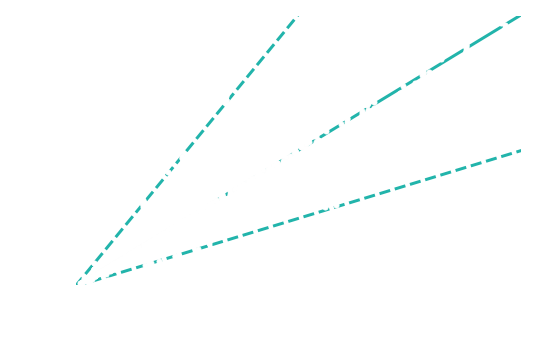

In [49]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,12,1), np.arange(0,12,1), c=parula_colors[120], 
         linewidth=3, zorder=1)
plt.plot(np.arange(0,12,1), np.arange(0,12,1)*2, c=parula_colors[120], 
         linewidth=3, zorder=1, linestyle='--')
plt.plot(np.arange(0,12,1), np.arange(0,12,1)*0.5, c=parula_colors[120], 
         linewidth=3, zorder=1, linestyle='--')

plt.plot(x[flags==0], y[flags==0], '.', c=COLOR, ms=10, zorder=4)

plt.xticks(np.arange(0,12,2))
plt.yticks(np.arange(0,12,2))
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel('$P_{rot}$ from First Observation [Days]')
plt.ylabel('$P_{rot}$ [Days]')

len(np.where( np.abs(x[flags==0]-y[flags==0]) < 0.2)[0])/ len(x[flags==0])
plt.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/compare_rots.png',
            rasterize=True, bbox_inches='tight', dpi=250, transparent=True)

## Rotation period vs. Teff

In [50]:
from astropy import constants as const

In [51]:
def planck(lam, T, rad):
    result = 2.*np.pi*const.h*(const.c**2)/(lam**5)
    exp = (const.h*const.c/(lam*const.k_B*T))#.to(u.m/u.m)
    result /= (np.exp(exp) - 1.0)
    #result *= (4* np.pi**2 * rad**2)
    result *= (lam[1]-lam[0])
    result = result.to(uni.erg/uni.s/uni.m**2) * (rad.to(uni.m))**2
    return result

In [52]:
(flare_table['dur_min']* uni.min).to(uni.s)

<Quantity [2351.96839207, 2346.31508553, 2358.80826778, ..., 2431.6204111 ,
           2343.76798456, 2341.09147411] s>

In [53]:
scaling = np.zeros(len(table))
calc_lum = np.zeros(len(table))
lam = np.arange(600,1000) * uni.nm

for i in tqdm_notebook(range(len(table))):
    star = planck(lam, table['teff_val'].data[i]*uni.K, 
                                table['rad'].data[i]*uni.Rsun).to(uni.erg/uni.s)
    # need to incorporate duration of flare
    # work through with made-up numbers first
    flare = planck(lam, 9000*uni.K,  table['rad'].data[i]*uni.Rsun).to(uni.erg/uni.s)
    scaling[i] = np.nansum(star.value) / np.nansum(flare.value)
    calc_lum[i] = np.nansum(star.value)

//anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [54]:
table.add_column(Column(scaling, 'scaling'))
table.add_column(Column(calc_lum, 'tess_lum'))

In [55]:
maxE = np.zeros(len(table))

for i in range(len(table)):
    subtab = flare_table[np.where(flare_table['Target_ID']==table['Target_ID'].data[i])[0]]
    if len(subtab) > 0:
        argmax = np.argmax(subtab['amp'])
        dur = subtab['dur_min'][argmax] * uni.min
        star = table['tess_lum'].data[i] * uni.erg/uni.s * table['scaling'].data[i]
        energy = (star * dur * subtab['amp'][argmax]).to(uni.erg)
        maxE[i] = energy.value

In [56]:
table.add_column(Column(maxE, 'max_energy'))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


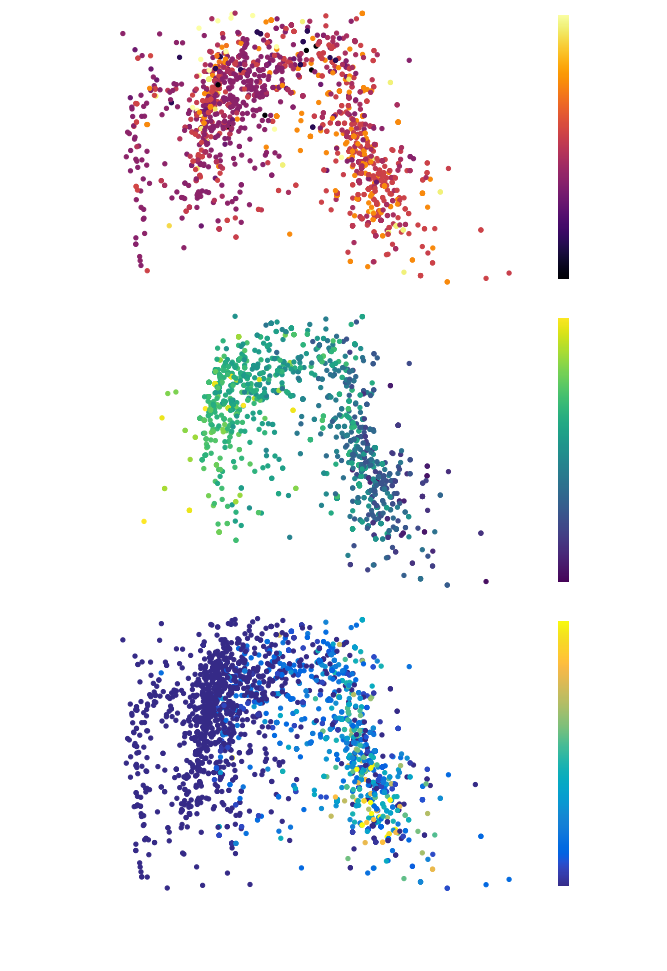

In [57]:
measured = table[(table['Flags']==0) | (table['Flags']==1)]


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(8,14), nrows=3,sharey=True, sharex=True)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05, 
                   hspace=0.08)

im = ax1.scatter(measured['Rp']-measured['Bp'],
            measured['avg_period_days'], c=np.log10(measured['YMG_age']), s=18,
            cmap='inferno')
ax1.set_ylim(0.1,12)
cm = fig.colorbar(im, ax=ax1, shrink=0.95)
cm.set_label('Age [Myr]', fontsize=20)
cm.set_ticks(np.arange(0.5,3,0.5))
cm.set_ticklabels([int(i) for i in np.round(10**np.arange(0.5,3,0.5))])

im = ax2.scatter(measured['Rp']-measured['Bp'],
                measured['avg_period_days'], 
                c=np.log10((measured['max_energy'])), s=18,
                cmap='viridis', vmin=29, vmax=35)
cm = fig.colorbar(im, ax=ax2, shrink=0.95)
cm.set_label('log$_{10}$(Max Flare Energy) [erg]', fontsize=20)

im = ax3.scatter(measured['Rp']-measured['Bp'],
                measured['avg_period_days'], 
                c=measured['weighted_rate'],
                s=18,
                cmap=parula, vmin=0, vmax=0.3)
cm = fig.colorbar(im, ax=ax3, shrink=0.95)
cm.set_label('Flare Rate [Day $^{-1}$]', fontsize=20)

#plt.xlim(0.6,-4.3)
ax3.set_xlabel('$Gaia$ $B_p-R_p$', fontsize=24)
#ax1.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax2.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax2.set_yscale('log')

#plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/combined_rot_plots.pdf', 
#            rasterize=True, dpi=250, bbox_inches='tight')

#plt.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/combined_rot_plots.png',
#            rasterize=True, dpi=250, bbox_inches='tight', transparent=True)

## Individual Plots

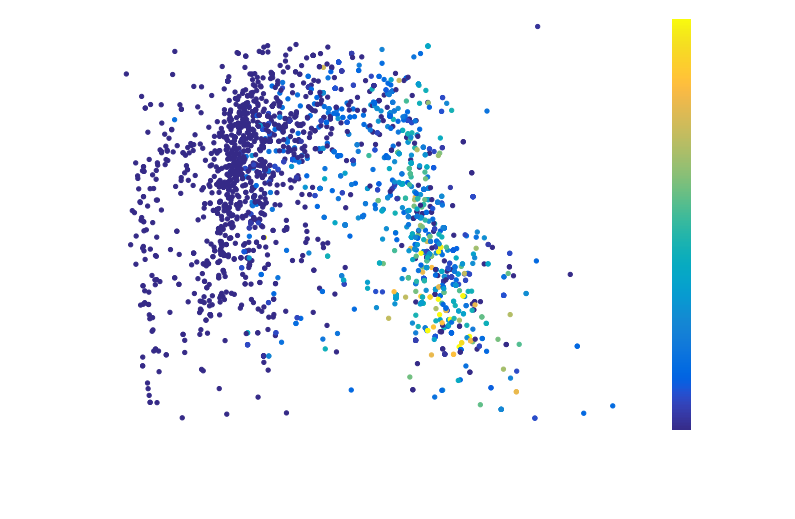

In [64]:
fig, ax3 = plt.subplots(figsize=(12,8))
im = ax3.scatter(measured['Rp']-measured['Bp'],
                measured['avg_period_days'], 
                c=measured['weighted_rate'],
                s=18,
                cmap=parula, vmin=0, vmax=0.3)
cm = fig.colorbar(im, ax=ax3, shrink=0.95)
cm.set_label('Flare Rate [Day $^{-1}$]', fontsize=24)

#plt.xlim(0.6,-4.3)
ax3.set_xlabel('$Gaia$ $B_p-R_p$', fontsize=24)
#ax1.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax3.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax3.set_yscale('log')

#plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/combined_rot_plots.pdf', 
#            rasterize=True, dpi=250, bbox_inches='tight')

plt.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/flare_rate_rot.png',
            rasterize=True, dpi=250, bbox_inches='tight', transparent=True)

In [ ]:
fig, ax3 = plt.subplots(figsize=(12,8))
im = ax3.scatter(measured['Rp']-measured['Bp'],
                measured['avg_period_days'], 
                c=measured['weighted_rate'],
                s=18,
                cmap=parula, vmin=0, vmax=0.3)
cm = fig.colorbar(im, ax=ax3, shrink=0.95)
cm.set_label('Flare Rate [Day $^{-1}$]', fontsize=24)

#plt.xlim(0.6,-4.3)
ax3.set_xlabel('$Gaia$ $B_p-R_p$', fontsize=24)
#ax1.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax3.set_ylabel('$P_{rot}$ [Days]', fontsize=24)
ax3.set_yscale('log')

#plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/combined_rot_plots.pdf', 
#            rasterize=True, dpi=250, bbox_inches='tight')

plt.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/flare_rate_rot.png',
            rasterize=True, dpi=250, bbox_inches='tight', transparent=True)

## Looks at flare distribution as a function of phase

In [65]:
peak_phase = np.array([])
peak_amp   = np.array([])
amp_tics   = np.array([], dtype=int)
phase_flag = np.array([], dtype=int)
amp_ages   = np.array([])

for tic in np.unique(table['Target_ID']):
    
    flag  = table[table['Target_ID']==tic]['Flags'].data[0]
    age   = table[table['Target_ID']==tic]['YMG_age'].data[0]
    period = table[table['Target_ID']==tic]['avg_period_days'].data[0]
    inds = np.where(TICS==tic)[0]
    accum_time = np.array([])
    accum_flux = np.array([])
    accum_phase = np.array([])
    
    for t in inds:
        if np.nanmax(phases[t])>0.3:
            accum_time = np.append(accum_time, QTIME[t])
            accum_flux = np.append(accum_flux, QFLUX[t])
            accum_phase = np.append(accum_phase, phases[t])

    flares = flare_table[flare_table['Target_ID']==tic]
    
    if (flag == 0 or flag == 1) and len(accum_phase) > 0 and period > 0.75:
        peaks  = flares['tpeak'].data
        amps   = flares['amp'].data

        for j in range(len(amps)):
            ti = np.where((accum_time >= peaks[j]) & 
                          (accum_time <= peaks[j]+0.1))[0]
            if len(ti) > 0:
                peak_phase = np.append(peak_phase, accum_phase[ti[0]])
                peak_amp   = np.append(peak_amp, amps[j])
                phase_flag = np.append(phase_flag, 0)
                amp_tics   = np.append(amp_tics, tic)
                amp_ages = np.append(amp_ages, age)
    else:
        amps   = flares['amp'].data
        for a in amps:
            peak_phase = np.append(peak_phase, -2)
            peak_amp = np.append(peak_amp, a)
            phase_flag = np.append(phase_flag, 1)
            amp_tics   = np.append(amp_tics, tic)
            amp_ages = np.append(amp_ages, age)

## Got all the flare amplitudes... Now what

Text(0, 0.5, '$N_{flares}$')

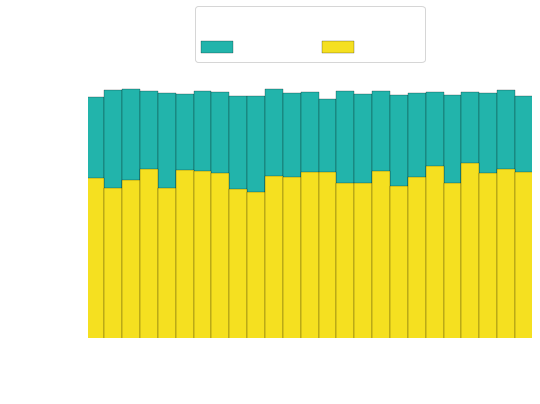

In [107]:
f = (phase_flag==0)

small = np.where((peak_amp<0.05) & (peak_amp>0.005) &
                 (peak_phase >=-0.5) & (peak_phase<=0.5))[0]# & (peak_amp>=1.01))
big = np.where((peak_amp>=0.05) & (peak_amp>0.005) &
                 (peak_phase >=-0.5) & (peak_phase<=0.5))[0]

plt.figure(figsize=(8,5))

plt.yscale('log')
bins = np.arange(-0.5,0.52,0.04)

y1, b1, _ = plt.hist(peak_phase[small], 
                     bins=bins, color=parula_colors[120],
                     label='< 5%', edgecolor='k', linewidth=0.25)
y2, b2, _ = plt.hist(peak_phase[big], 
                     bins=bins, color=parula_colors[240],
                     label='$\geq$ 5%', edgecolor='k', linewidth=0.25)
#plt.yticks([10,100,500, 800])
plt.xlim(-0.5,0.5)
plt.yticks([10**0, 10**1, 10**2, 5*10**2], labels=[10**0, 
                                                   10**1, 
                                                   10**2, 
                                                   5*10**2])
plt.ylim(1,500)
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center',
                    ncol=2,  borderaxespad=0., fontsize=16)
legend.set_title('Flare Amplitude')
#plt.facecolor = False

plt.xlabel('Phase')
plt.ylabel('$N_{flares}$')

#plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/phase.pdf',
#            dpi=250, rasterize=True,
#            bbox_inches='tight')

#plt.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/phase.png',
#            dpi=250, rasterize=True,
#            bbox_inches='tight', transparent=True)

In [67]:
def sine_wave(args, x):
    amp, offset = args
    return amp * np.sin((x*2*np.pi-1*np.pi/2.)) + offset
def sine_chi(args, x, y, n):
    sine = sine_wave(args,x)
    return np.nansum((y-sine)**2/n**2)
def sine_resid(args, x, y, n):
    sine = sine_wave(args,x)
    return (y-sine)/n

NameError: name 'leastsq' is not defined

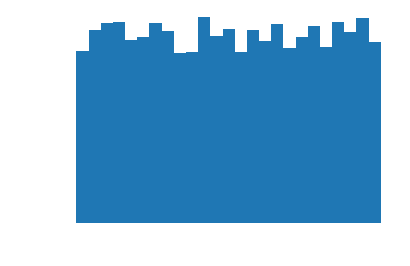

In [68]:
bins = np.arange(-0.5,0.52,0.04)

yall, ball, _ = plt.hist(peak_phase[f], bins=bins)

n, _ = np.histogram(peak_phase[f], bins=bins)

results = minimize(sine_chi, x0=[10,600],
                       args=(ball[2:], yall[1:], np.sqrt(n[1:])), 
                       method='L-BFGS-B')
    
results2 = leastsq(sine_resid, results.x,
                   args=(ball[2:], yall[1:], np.sqrt(n[1:])),
                   full_output=True)

plt.plot(ball[1:], yall, 'ko')
plt.plot(ball[1:], sine_wave((10,600), ball[1:]), 'b')
plt.plot(ball[1:], sine_wave((results2[0][0],results2[0][1]), ball[1:]), 'r')
plt.ylim(1,1400)
plt.yscale('log')
#plt.plot(b2[1:], y2, 'wo')

In [24]:
semi_amp = -18+(7.6*3) # 3-sigma semi-amplitude (can rule out anything bigger)
amp = semi_amp * 2
# 664 +/- amp
(1-(664-amp)/(664+amp))*100 # can rule out differences of 3% from peak to trough
# can rule out coverages < 3% different

# we see averaged 2% variability, but it must be spotty and less-spotty hemispheres, 
# but we can say can coverage is high due to real small 3% difference in flares at each phase
# v different from the Sun

2.8503562945368266

## Age & Temperature Bins

In [80]:
AGE_RANGE = np.array([0,10,20,40,60,140,160,560,580])

## Flare amplitudes per temperature bin

In [81]:
TEMP_BINS = np.array([2300, 3500, 4000, 4500, 5000, 6200, 15000])

all_weights_per_bin = np.zeros(len(TEMP_BINS)-1, dtype=np.ndarray)
all_amps_per_bin    = np.zeros(len(TEMP_BINS)-1, dtype=np.ndarray)
all_ages_per_bin    = np.zeros(len(TEMP_BINS)-1, dtype=np.ndarray)
all_tics_per_bin    = np.zeros(len(TEMP_BINS)-1, dtype=np.ndarray)

for z in range(len(TEMP_BINS)-1):
    subtab = table[(table['teff_val']>=TEMP_BINS[z]) &
                   (table['teff_val']<TEMP_BINS[z+1]) &
                   (table['YMG_age']!=0.0) & (table['YMG'] != 'None')]
    temp_weights = np.array([])
    temp_amps = np.array([])
    temp_ages = np.array([])
    temp_tics = np.array([], dtype=int)
    
    for tic in np.unique(subtab['Target_ID']):
        prop = table[table['Target_ID']==tic][0]
        #lum = (prop['lum']*uni.Lsun).to(uni.erg/uni.s)
        lum = prop['tess_lum']*uni.erg/uni.s
        scale = prop['scaling']
        crossmatch = flare_table[flare_table['Target_ID']==tic]
        
        if len(crossmatch) == prop['Nflares_large']+prop['Nflares_small']:
            
            for a in range(len(crossmatch)):
                temp_weights = np.append(temp_weights, 
                                         prop['total_observed_time']*crossmatch['prob'].data[a])
                dur = crossmatch['dur_min'].data[a] * uni.min
                flare = (crossmatch['amp'].data[a]*lum*dur*scale)
                temp_amps = np.append(temp_amps, flare.to(uni.erg).value)
                temp_ages = np.append(temp_ages, prop['YMG_age'])
                temp_tics = np.append(temp_tics, tic)
                
    all_weights_per_bin[z] = temp_weights
    all_amps_per_bin[z]    = temp_amps
    all_ages_per_bin[z]    = temp_ages
    all_tics_per_bin[z]    = temp_tics

//anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)
//anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


## Stacked histograms

In [84]:
def stacked_histogram_ages(all_ages, all_amps, all_weights, tics, age_cutoff=50,
                          where='paper'):
    global TEMP_BINS
    
    plt.rcParams['font.size'] = 18
    fig, axes = plt.subplots(ncols=int(len(TEMP_BINS)/2), 
                             nrows=2, figsize=(14,6),
                             sharex=True, sharey=True)

    if where == 'paper':
        color1 = acolors[1] #acolors[6] #
        color2 = acolors[8] #acolors[10] #
    else:
        color1 = acolors[6]
        color2 = acolors[10]
    
   # bins = np.logspace(0, 18/7., 19)
    bins = np.logspace(29, 35, 23)
    
    z = 0
    for ax in axes.reshape(-1):
#        _, u = np.unique(all_tics_per_bin[z], return_index=True)
        
        all_old = np.where((all_ages[z] >= age_cutoff))[0]
        all_young = np.where((all_ages[z] < age_cutoff))[0]
        
        _,u = np.unique(tics[z][all_old], return_index=True)
        weight_old = all_weights[z][all_old][u]
        
        _,u = np.unique(tics[z][all_young], return_index=True)
        weight_young = all_weights[z][all_young][u]

       # weights = all_weights[z]
        amps    = all_amps[z]
        
        if z == 4:
            #ax.set_xlabel('Flare Amplitude [%]', fontsize=22)
            ax.set_xlabel('Flare Energy [erg]', fontsize=22)
        if z == 3:
            ax.set_ylabel('Flare Rate [Day$^{-1}$]', y=1.1, fontsize=22)

        
        ax.hist(amps[all_old]*100,
                bins=bins, color=color2, alpha=0.2,
                weights=np.full(len(all_old), 1/np.nansum(weight_old)),#/len(all_old),
                histtype='bar')
        ax.hist(amps[all_young]*100, 
                bins=bins, color=color1, alpha=0.2,
                weights=np.full(len(all_young), 1/np.nansum(weight_young)),#/len(all_young),
                histtype='bar')
        
        # Outline
        ax.hist(amps[all_young]*100, 
                bins=bins, color=color1,
                edgecolor=color1, linewidth=2, fill=None,
                weights=np.full(len(all_young), 1/np.nansum(weight_young)),#/len(all_young),
                histtype='bar')#, label='$\leq$ {}'.format(age_cutoff))
        ax.hist(amps[all_old]*100,
                bins=bins, color=color2,fill=None,
                edgecolor=color2, linewidth=2, 
                weights=np.full(len(all_old), 1/np.nansum(weight_old)),#/len(all_old),
                histtype='bar')#, label='> {}'.format(age_cutoff))
    
        # Legend
        ax.hist(amps[all_young]/1e10, 
                bins=bins, color=color1,
                edgecolor=color1, linewidth=4, fill=None,
                weights=np.full(len(all_young), 1/np.nansum(weight_young)),#/len(all_young),
                histtype='bar', label='$\leq$ {}'.format(age_cutoff))
        ax.hist(amps[all_old]/1e10,
                bins=bins, color=color2,fill=None,
                edgecolor=color2, linewidth=4, 
                weights=np.full(len(all_old), 1/np.nansum(weight_old)),#/len(all_old),
                histtype='bar', label='> {}'.format(age_cutoff))
    

        if z == 1:
            ax.legend(bbox_to_anchor=(0., 1.06, 1.0, .102), loc='lower center',
                    ncol=2,  borderaxespad=0., fontsize=16, title='Age [Myr]')
            #ax.legend(fontsize=18, title='Age [Myr]',
            #          bbox_to_anchor=(1, -0.35, 0.65, 0.0),
            #          loc='lower right', mode='expand')
        
        
        ax.set_ylim(3*10**-4, 3*10**-1)
        
        #ax.set_xlim(10**29,10**35)
        #ax.set_ylim(-1,0)
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        #ax.set_xticks([1, 10, 100])
        #ax.set_xticklabels(['1', '10', '100'])
        
        
        #ax.set_xscale('log')
        
        #ax.set_xticklabels(np.arange(0,125,25))

        ax.set_title('{}-{} K'.format(TEMP_BINS[z], TEMP_BINS[z+1]),
                 y=0.81, fontweight='bold', loc='center')

        z += 1

    plt.subplots_adjust()
    return fig

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars


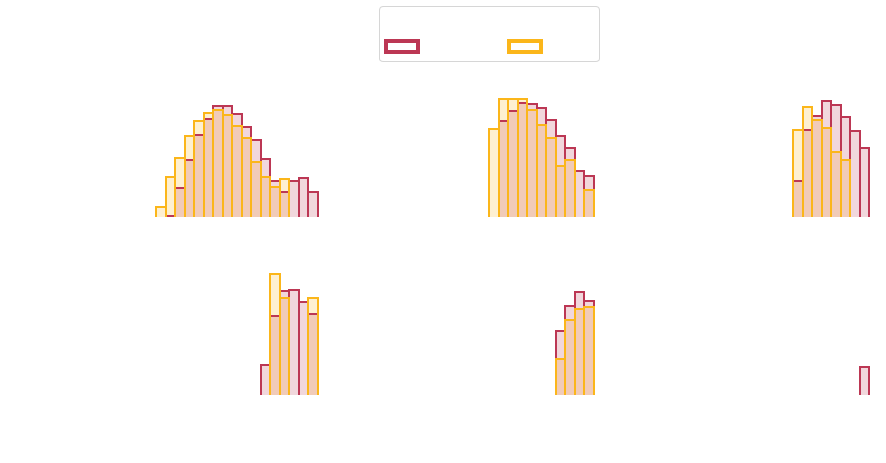

In [86]:
%matplotlib inline
fig = stacked_histogram_ages(all_ages_per_bin, 
                             all_amps_per_bin,
                             all_weights_per_bin,
                             all_tics_per_bin,
                             age_cutoff=50,
                             where='presentation')
#fig.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/byage.pdf',
#            dpi=250, rasterize=True,
#            bbox_inches='tight')#, transparent=True)
fig.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/byage.png',
            dpi=250, rasterize=True,
            bbox_inches='tight', transparent=True)

## Bin by age and effective temperature

In [87]:
AGE_BINS = np.array([1, 20, 30, 45, 125, 300, 800])

all_weights_per_age = np.zeros(len(AGE_BINS)-1, dtype=np.ndarray)
all_amps_per_age    = np.zeros(len(AGE_BINS)-1, dtype=np.ndarray)
all_ages_per_age    = np.zeros(len(AGE_BINS)-1, dtype=np.ndarray)
all_temps_per_age   = np.zeros(len(AGE_BINS)-1, dtype=np.ndarray)
all_tics_per_age    = np.zeros(len(AGE_BINS)-1, dtype=np.ndarray)

for z in range(len(AGE_BINS)-1):
    subtab = table[(table['YMG_age']>=AGE_BINS[z]) &
                   (table['YMG_age']<AGE_BINS[z+1]) &
                   (table['YMG_age']!=0.0) & (table['YMG'] != 'None')]
    
    temp_weights = np.array([])
    temp_amps = np.array([])
    temp_ages = np.array([])
    temp_temp = np.array([])
    temp_tics = ([])
    
    for tic in np.unique(subtab['Target_ID']):
        prop = table[table['Target_ID']==tic][0]
        lum = prop['tess_lum']*uni.erg/uni.s
        scale = prop['scaling']
        crossmatch = flare_table[flare_table['Target_ID']==tic]
        
        if len(crossmatch) == prop['Nflares_large']+prop['Nflares_small']:
            for a in range(len(crossmatch)):
                temp_weights = np.append(temp_weights, 
                                         prop['total_observed_time']*crossmatch['prob'].data[a])
                dur = crossmatch['dur_min'].data[a] * uni.min
                flare = (crossmatch['amp'].data[a]*lum*dur*scale).to(uni.erg)
                #print(flare)
                temp_amps = np.append(temp_amps, flare.value)
                temp_temp = np.append(temp_temp, prop['teff_val'])
                temp_ages = np.append(temp_ages, prop['YMG_age'])
                temp_tics = np.append(temp_tics, prop['Target_ID'])
                
    all_weights_per_age[z] = temp_weights
    all_amps_per_age[z]    = temp_amps
    all_ages_per_age[z]    = temp_ages
    all_temps_per_age[z]   = temp_temp
    all_tics_per_age[z]    = temp_tics

In [88]:
def stacked_histogram_temp(all_temps, all_amps, 
                           all_weights, tics, temp_cutoff=4000,
                           where='paper'):
    global AGE_BINS
    
    plt.rcParams['font.size'] = 18
    fig, axes = plt.subplots(ncols=int(len(AGE_BINS)/2), 
                             nrows=2, figsize=(14,6),
                             sharex=True, sharey=True)

    if where == 'paper':
        color1 = colors[1]#colors[6]#
        color2 = colors[8]#colors[11]#
    else:
        color1 = colors[6]
        color2 = colors[11]

    #bins = np.logspace(0, 18/7., 19)
    bins = np.logspace(29, 35, 19)
    
    z = 0
    for ax in axes.reshape(-1):
        
        all_hot = np.where((all_temps[z] >= temp_cutoff))[0]
        all_cool = np.where((all_temps[z] < temp_cutoff))[0]
        
        _,u = np.unique(tics[z][all_hot], return_index=True)
        weight_hot = all_weights[z][all_hot][u]
        
        _,u = np.unique(tics[z][all_cool], return_index=True)
        weight_cool = all_weights[z][all_cool][u]

        amps    = all_amps[z]
        
        if z == 4:
            ax.set_xlabel('Flare Energy [erg]', fontsize=22)
        if z == 3:
            ax.set_ylabel('Flare Rate [Day$^{-1}$]', y=1.1, fontsize=22)

        ax.hist(amps[all_cool]*100, 
                bins=bins, color=color1, alpha=0.2,
                edgecolor='black', linewidth=0.25, 
                weights=np.full(len(all_cool), 1/np.nansum(weight_cool)),
                histtype='bar')
        ax.hist(amps[all_hot]*100,
                bins=bins, color=color2, alpha=0.2,
                edgecolor='black', linewidth=0.25, 
                weights=np.full(len(all_hot), 1/np.nansum(weight_hot)),
                histtype='bar')
        
        ax.hist(amps[all_cool]*100, 
                bins=bins, color=color1, 
                edgecolor=color1, linewidth=2, fill=None,
                weights=np.full(len(all_cool), 1/np.nansum(weight_cool)),
                histtype='bar')#, label='$\leq$ {}'.format(temp_cutoff))
        ax.hist(amps[all_hot]*100,
                bins=bins, color=color2, 
                edgecolor=color2, linewidth=2, fill=None,
                weights=np.full(len(all_hot), 1/np.nansum(weight_hot)),
                histtype='bar')#, label='> {}'.format(temp_cutoff))
        
        ax.hist(amps[all_cool]/1e10, 
                bins=bins, color=color1, 
                edgecolor=color1, linewidth=4, fill=None,
                weights=np.full(len(all_cool), 1/np.nansum(weight_cool)),
                histtype='bar', label='$\leq$ {}'.format(temp_cutoff))
        ax.hist(amps[all_hot]/1e10,
                bins=bins, color=color2, 
                edgecolor=color2, linewidth=4, fill=None,
                weights=np.full(len(all_hot), 1/np.nansum(weight_hot)),
                histtype='bar', label='> {}'.format(temp_cutoff))

        if z == 1:
            ax.legend(bbox_to_anchor=(0., 1.06, 1.0, .102), loc='lower center',
                    ncol=2,  borderaxespad=0., fontsize=16, title='$T_{eff}$ [K]')
            
        #ax.set_xlim(1,300)
        ax.set_ylim(3*10**-4, 2*10**-1)
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        #ax.set_xticks([1, 10, 100])
        #ax.set_xticklabels(['1', '10', '100'])

        ax.set_title('{}-{} Myr'.format(AGE_BINS[z], AGE_BINS[z+1]),
                 y = 0.81, fontweight='bold', loc='center')

        z += 1

    plt.subplots_adjust()
    return fig

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


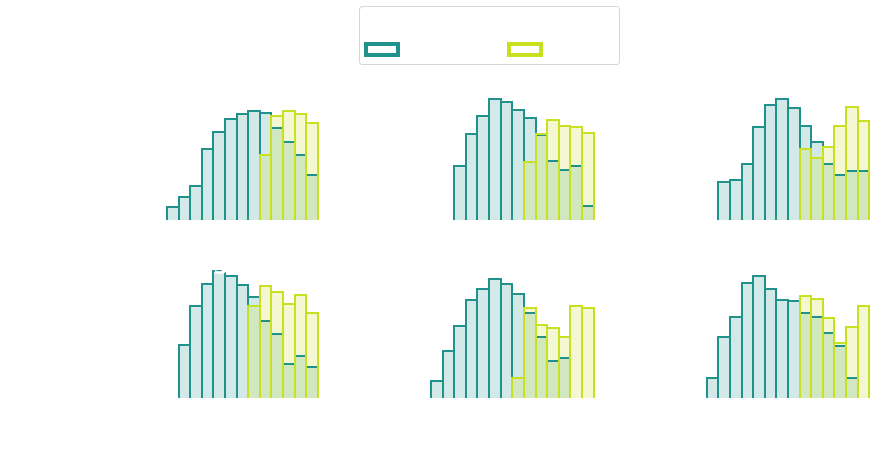

In [89]:
%matplotlib inline
fig = stacked_histogram_temp(all_temps_per_age, 
                             all_amps_per_age,
                             all_weights_per_age,
                             all_tics_per_age,
                             temp_cutoff=4000,
                             where='presentation')
#fig.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/byteff.pdf', 
#            dpi=250, rasterize=True,
#            bbox_inches='tight')#, transparent=True)
fig.savefig('/Users/arcticfox/Documents/youngStars/presentationFigures/byteff.png',
            dpi=250, rasterize=True,
            bbox_inches='tight', transparent=True)

## Flare Frequency Distribution

In [26]:
from scipy.optimize import leastsq

In [528]:
all_amps, all_weights = np.array(all_amps_per_bin[0]), np.array(all_weights_per_bin[0])
all_tics = np.array(all_tics_per_bin[0])
all_ages = np.array(all_ages_per_bin[0])

for i in range(1, len(all_amps_per_bin)):
    all_amps = np.append(all_amps, all_amps_per_bin[i])
    all_weights = np.append(all_weights, all_weights_per_bin[i])
    all_tics = np.append(all_tics, all_tics_per_bin[i])
    all_ages = np.append(all_ages, all_ages_per_bin[i])
all_amps *= 100

In [551]:
all_amps, all_weights = np.array(all_amps_per_age[0]), np.array(all_weights_per_age[0])
all_tics = np.array(all_tics_per_age[0])
all_temps = np.array(all_ages_per_age[0])

for i in range(1, len(all_amps_per_bin)):
    all_amps = np.append(all_amps, all_amps_per_age[i])
    all_weights = np.append(all_weights, all_weights_per_age[i])
    all_tics = np.append(all_tics, all_tics_per_age[i])
    #all_ages = np.append(all_ages, all_ages_per_age[i])
    all_temps = np.append(all_temps, all_temps_per_age[i])

In [552]:
len(all_ages), len(all_tics)

(13951, 14478)

In [553]:
def linear_fit(args, x, y, num):
    m, b = args
    fit = m*x+b#b * x**m 
    return np.nansum((y-fit)**2/num**2)

def linear(args, x):
    m, b = args
    fit = m*x+b#b * x**m
    return fit

def power_law(args, x):
    m, b = args
    fit = b * x**m
    return fit

def linear_resid(args, x, y, num):
    m, b = args
    fit = m*x+b#b * x**m 
    return (y-fit)/num

def power_law_resid(args, x, y, num):
    m, b = args
    fit = b * x**m 
    return (y-fit)/num

In [768]:
def ffd_function(tics, amps, weights, ax, color):
    #bins = np.logspace(0, 18/7., 19)
    bins = np.logspace(29,35,23)

    _, uniargs = np.unique(tics, return_index=True)

    n, _ = np.histogram(amps, bins=bins)


    y, binedges, _ = ax.hist(amps, bins=bins, 
                             weights=np.full(len(amps), 
                                              1/np.nansum(weights[uniargs])) ,
                             alpha=0.2,
                             color=color)
    x = binedges[1:] + 0.0
    logx = np.log10(x)

    i = 11
    j = 18

    plt.plot(logx[i:j], np.log10(n[i:j]), '.', c=color)
    plt.plot(logx[i:j], linear([-1.4, 47], logx[i:j]), '--', c=color, linewidth=3)

    
    results = minimize(linear_fit, x0=[-1.4, 47],
                       args=(logx[i:j-1]-np.diff(logx[i:j])/2., 
                             np.log10(n[i:j-1]), np.sqrt(np.log10(n[i:j-1])) ), 
                       bounds=( (-3.0, 0.0), (-100, 100)),
                       method='L-BFGS-B')#, 
                       #options={'ftol':1e-8, 'gtol':1e-7})

    results.x[1] = 10**results.x[1]

    results2 = leastsq(power_law_resid, results.x,
                       args=(x[i:j-1]-np.diff(x[i:j])/2., 
                             n[i:j-1], 
                             np.sqrt(n[i:j-1]) ),
                       full_output=True)

    fit_params = results2[0]
    
    slope_err = np.sqrt(results2[1][0][0])

    model = linear([fit_params[0], np.log10(fit_params[1])], logx[10:])
    ax.plot(logx[10:], model, c=color)

    print(fit_params[0], slope_err)

    return fit_params

------- BY TEFF -------
-0.5870458874893902 0.030546298209903767
-0.5717787662174246 0.04042290842542662
------- BY AGE -------
-0.5847273771846709 0.025387779055329508


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-0.5238663066816662 0.07985752964447733


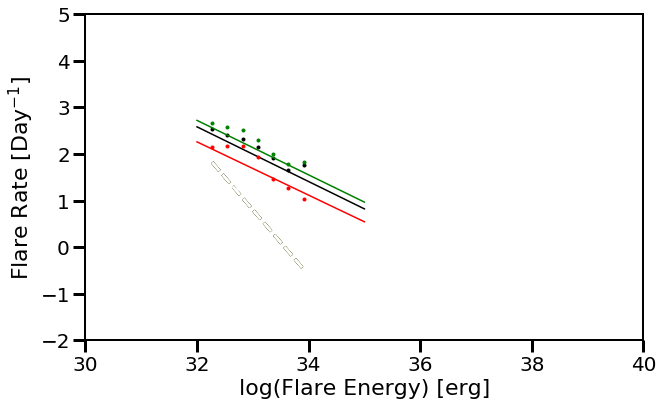

In [769]:
fig, ax = plt.subplots(ncols=1, figsize=(10,6))

bins = np.logspace(29,35,23)

print("------- BY TEFF -------")

mask1 = all_temps <= 4000
mask2 = all_temps > 4000

ffd_function(all_tics[mask1], all_amps[mask1], 
             all_weights[mask1], ax, color='k')
ffd_function(all_tics[mask2], all_amps[mask2], 
             all_weights[mask2], ax, color='r')

print("------- BY AGE -------")

mask1 = all_ages <= 50
mask2 = all_ages > 50

ffd_function(all_tics_a[mask1], all_amps_a[mask1], 
             all_weights_a[mask1], ax, color='g')
ax.set_xlim(30,40)
ax.set_ylim(-2,5)
ffd_function(all_tics_a[mask2], all_amps_a[mask2], 
             all_weights_a[mask2], ax, color='w')

#ax.set_ylim(3*10**-1, 10**1)


ax.set_xlabel('log(Flare Energy) [erg]', fontsize=22)
ax.set_ylabel('Flare Rate [Day$^{-1}$]', fontsize=22)

#ax.set_yscale('log')
#ax.set_xscale('log')

plt.show()

## Example Light Curves

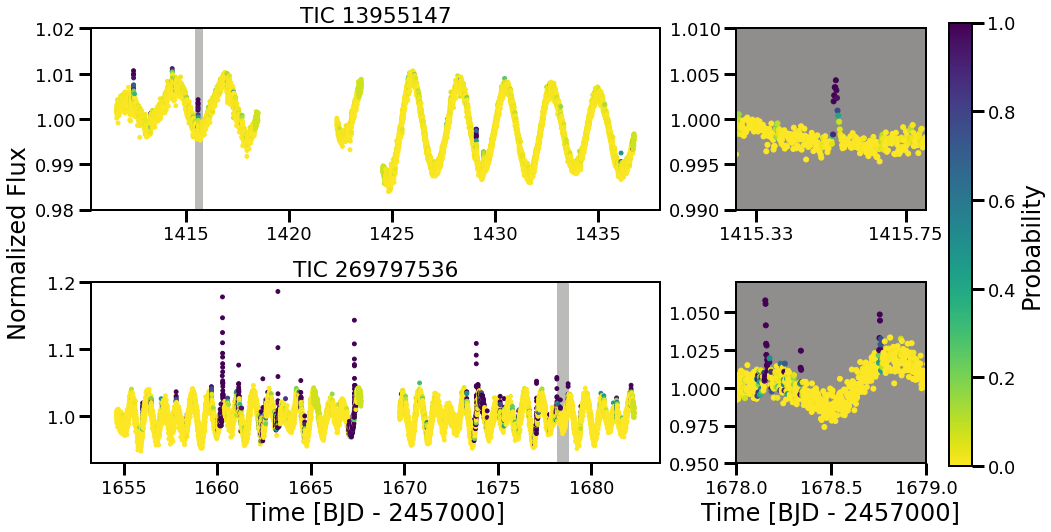

In [30]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8), 
                                             gridspec_kw={'width_ratios':[3,1]})

highlight='#8f8e8d'

inds = np.where(TICS==13955147)[0]
ax1.set_title('TIC 13955147')
for i in inds[0:1]:
    ax1.scatter(QTIME[i], QFLUX[i], c=QPRED[i], vmin=0, vmax=1,
                cmap='viridis_r', s=15)
ax3.scatter(QTIME[inds[0]], QFLUX[inds[0]], c=QPRED[inds[0]], vmin=0, vmax=1,
         cmap='viridis_r', s=25)
ax1.set_ylim(0.98,1.02)
ax3.set_ylim(0.99,1.01)
#ax3.set_yticklabels([])
ax3.set_xlim(1415.33, 1415.8)
ax1.vlines(1415.6, 0,2, linewidth=8, alpha=0.6, color=highlight, zorder=0)
ax3.set_facecolor(highlight)
ax3.set_xticks([1415.38, 1415.75])
ax3.set_xticklabels(['1415.33', '1415.75'])
    
inds = np.where(TICS==269797536)[0]
ax2.set_title('TIC 269797536')
for i in inds[5:6]:
    im = ax2.scatter(QTIME[i], QFLUX[i], c=QPRED[i], vmin=0, vmax=1,
                     cmap='viridis_r',s=15)
ax4.scatter(QTIME[inds[5]], QFLUX[inds[5]], c=QPRED[inds[5]], vmin=0, vmax=1,
         cmap='viridis_r', s=25)
ax2.set_ylim(0.93,1.2)    
ax4.set_ylim(0.95,1.07)  
#ax4.set_yticklabels([])
ax4.set_xlim(1678,1679)
ax2.vlines(1678.5, 0,2, linewidth=12, alpha=0.6, color=highlight, zorder=0)
#ax4.set_xticks([1673.75, 1673.95])
ax4.set_facecolor(highlight)
#ax4.set_xticklabels(['1673.75', '1673.95'])

ax1.set_ylabel('Normalized Flux',  y=-0.18, fontsize=24)
ax2.set_xlabel('Time [BJD - 2457000]', fontsize=24)
ax4.set_xlabel('Time [BJD - 2457000]', fontsize=24)

fig.subplots_adjust(right=0.85, hspace=0.4, wspace=0.2)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.77])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Probability', fontsize=24)

plt.savefig('/Users/arcticfox/Desktop/example_lcs.png',
            rasterize=True, bbox_inches='tight', dpi=150)#,
#            transparent=True)

In [ ]:
count_dict = {}
for i in np.arange(1,14,1):
    count_dict[i] = 0
    
for t in np.unique(table['Target_ID']):
    row = table[table['Target_ID']==t]
    count_dict[int(len(row))] += 1

In [ ]:
count_dict

In [ ]:
len(np.unique(table['Target_ID']))

In [ ]:
suum = 0
for i in range(4,14):
    suum+=count_dict[i]

In [ ]:
suum

## The Big Bois

In [ ]:
fig, ((ax1,ax5), (ax2, ax6), (ax3,ax7), (ax4,ax8)) = plt.subplots(nrows=4, ncols=2, 
                                                                  figsize=(14,14),
                                                                   gridspec_kw={'width_ratios':[1.5,1]})
axes = [ax1,ax2,ax3,ax4]
axes2= [ax5,ax6,ax7,ax8]
z = -1

letters = ['a', 'b', 'c', 'd']

highlight='#e3dfdb'
lowlim = [0.5, 0.95, 0.9, 0.95]
upplim = [1.8, 1.2, 1.2, 1.2]
loc = [1.63, 1.165, 1.155, 1.165]

for tic in [24721262, 77954300, 206544316,44678751]:
    where = np.argmax(flare_table[flare_table['Target_ID']==tic]['amp'])
    tpeak = flare_table[flare_table['Target_ID']==tic]['tpeak'].data[where]
    amp   = flare_table[flare_table['Target_ID']==tic]['amp'].data[where]
    inds = np.where(TICS==tic)[0]
   
    teff = table[table['Target_ID']==tic]['teff_val'][0]
    age = table[table['Target_ID']==tic]['YMG_age'][0]
    #plt.title('TIC {}, Teff={}'.format(tic, teff))

    for i in inds:
        q = ((TIME[i]>=tpeak-0.4) & (TIME[i]<=tpeak+0.4))
        if len(TIME[i][q]) > 0:
            print(tic, '$T_{eff} = ', int(teff), '$')
            print(table[table['Target_ID']==tic]['YMG'][0], age)
            ax = axes[np.abs(z)-1]
            
            diff = np.diff(TIME[i])
            orbit = np.where(diff >= np.nanmedian(diff)+12*np.nanstd(diff))[0][0]

            ax.vlines(tpeak, 0, 100, linewidth=22, color=highlight)
            ax.plot(TIME[i][0:orbit-1], FLUX[i][0:orbit-1], 
                     linewidth=3, c=acolors[(np.abs(z))*2])
            ax.plot(TIME[i][orbit+50:], FLUX[i][orbit+50:], 
                     linewidth=3, c=acolors[(np.abs(z))*2])
            
            ax.set_ylim(lowlim[int(np.abs(z)-1)], upplim[int(np.abs(z)-1)])
            ax.set_xlim(TIME[i][0], TIME[i][-1])
            ax.set_facecolor('w')
            ax.text(TIME[i][100], loc[np.abs(z)-1], 
                    '({0}) {1} Myr'.format(letters[np.abs(z)-1].capitalize(), int(age)),
                    fontsize=22, fontweight='bold')
            
            if np.abs(z)-1==1:
                ax.set_ylabel('Normalized Flux', fontsize=28, y=-0.15)
              #  ax.set_yticks([1,3,5])
            if np.abs(z)-1==3:
                ax.set_xlabel('Time [BJD - 2457000]', fontsize=28)
              #  ax.set_yticks([1,5,10])
            
            ax = axes2[np.abs(z)-1]
            ax.plot(TIME[i][q], FLUX[i][q],
                     linewidth=3, c=acolors[(np.abs(z))*2])
            ax.set_xlim(TIME[i][q][0],TIME[i][q][-1])
            ax.set_xticks(np.round([tpeak-0.3, tpeak, tpeak+0.3],1))
            ax.set_ylim(np.nanmin(FLUX[i])-0.2, amp+1.5)
            ax.set_facecolor(highlight)
            #ax.set_yticklabels([])
            
            if np.abs(z)-1==3:
                ax.set_xlabel('Time [BJD - 2457000]', fontsize=28)
                ax.set_yticks([1,5,10])
            if np.abs(z)-1==1:
                ax.set_yticks([1,3,5])
            
            
   
    #plt.xlim(tpeak-0.5, tpeak+0.5)
    #plt.ylim(0.8, amp+1.5)
    #plt.show()
    z -= 1
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/large_ones.pdf',
#            rasterize=True, bbox_inches='tight', dpi=200)

In [ ]:
table[(table['Target_ID']==24721262)]

## Getting huge flare parameters

In [343]:
from astroquery.mast import Catalogs
from astropy import units
from astropy import constants
from scipy.optimize import minimize
from scipy.signal import medfilt
from scipy.interpolate import interp1d

In [464]:
def chiSqure(args, x, y, e, tpeak):
    amp, rise, fall = args
    model, _ = stella.utils.flare_lightcurve(x, tpeak,
                                             amp, rise,
                                             fall)
    return np.nansum((y-model)**2/e**2)

In [465]:
highEflares = [24721262, 77954300, 206544316,44678751]

tmag_9000 = table[table['Target_ID']==467773371]['teff_val'][0]
r = Catalogs.query_object('TIC467773371', catalog='TIC', radius=.02)[0]
dist_9000 = r['d']
tmag_9000 = r['Tmag']
vmag_9000 = r['Vmag']
print(tmag_9000, dist_9000, vmag_9000)

# {\displaystyle M=m-5\log _{10}(d_{\text{pc}})+5,}
Tmag_9000 = tmag_9000 - 5 * np.log10(dist_9000) + 5
print(Tmag_9000, vmag_9000)

7.737 138.044 7.86
2.0369123248236853 7.86


In [466]:
def to_tmag(V, J, H):
    return V - 0.28408*(J - H)**3 + 0.75955*(J - H)**2 - 1.96827*(J - H) - 0.1140 #(Stassun, 2017)

nan
9.536513485367345e+30 erg / s 3.8621725559999995e+30 erg / s


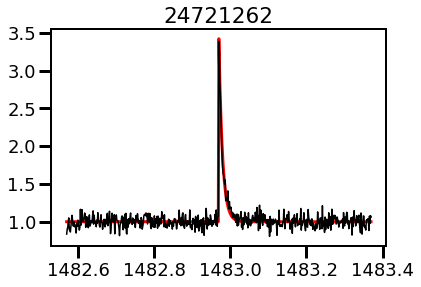

In [467]:
for hef in highEflares[0:1]:
    inds = np.where(TICS==hef)[0]
    subtab = flare_table[(flare_table['Target_ID']==hef) & (flare_table['amp']>2)][0]
    
    for i in inds:
        q = ((TIME[i]>=subtab['tpeak']-0.4) & (TIME[i]<=subtab['tpeak']+0.4))
        
        if len(TIME[i][q]) > 0:
            argwhere = np.where(TIME[i][q]==subtab['tpeak'])[0]
            m = np.append(np.arange(0,argwhere-5,1,dtype=int),
                          np.arange(argwhere+10,len(TIME[i][q]),1,dtype=int))
            
            dur = subtab['dur']#[0]
            dur = (dur * u.day).to(u.s)
            amp = subtab['amp']#[0]
            r = Catalogs.query_object('TIC{}'.format(hef), catalog='TIC', radius=.02)[0]
            lum = (r['lum'] * u.Lsun).to(u.erg/u.s)

            flare_mag = np.abs(2.5*np.log10(amp+1) - r['Tmag'])

            print(to_tmag(r['Vmag'], r['Jmag'], r['Hmag']) - flare_mag)
           # print(to_tmag(r['Vmag'], r['Jmag'], r['Hmag']))

            x = minimize(chiSqure, x0=(subtab['amp'], subtab['rise'], subtab['fall']),
                         args=(TIME[i][q], FLUX[i][q], np.ones(len(FLUX[i][q])), argwhere),
                         method='L-BFGS-B')
                               
            model, params = stella.utils.flare_lightcurve(TIME[i][q], argwhere,
                                                 x.x[0], x.x[1],
                                                 x.x[2])
            time = (TIME[i][q] * u.day).to(u.hour)
            dur = np.abs(np.sum(model[model!=1][1:] * np.diff(time[model!=1]) ))
            print(lum*subtab['amp'], lum)
            plt.plot(TIME[i][q], model, 'r', linewidth=3)
            plt.plot(TIME[i][q], FLUX[i][q], 'k')
            plt.title(hef)
            plt.show()

In [691]:
dur

<Quantity 40.02368725 min>

In [690]:
lum, lum*crossmatch['amp']*dur.to(uni.s)

(<Quantity 6.75409001e+34 erg / s>, <Quantity [2.66392845e+35] erg>)

## Examples for Rotation Flagging

In [ ]:
fig, ((ax1,ax5), (ax2, ax6), (ax3,ax7), (ax4,ax8)) = plt.subplots(nrows=4, ncols=2, 
                                                                  figsize=(14,14),
                                                                  gridspec_kw={'width_ratios':[1.5,1]})
axes = [ax1,ax2,ax3,ax4]
axes2= [ax5,ax6,ax7,ax8]
z = -1

letters = ['(A)', '(B)', '(C)', '(D)']
loc = [1.007, 1.003,1.014,1.056]

for tic in [3837491, 408017296, 250419751, 1273249]:
    inds = np.where(TICS==tic)[0]
    for i in inds[0:1]:
        ax = axes[np.abs(z)-1]
        
        diff = np.diff(QTIME[i])
        orbit = np.where(diff >= np.nanmedian(diff)+12*np.nanstd(diff))[0]
        steps = np.append([0,len(QFLUX[i])], orbit)
        steps = np.sort(steps)
        for s in range(len(steps)-1):
            ax.plot(QTIME[i][steps[s]+5:steps[s+1]], QFLUX[i][steps[s]+5:steps[s+1]], 
                     linewidth=3, c=colors[(np.abs(z))])
           # ax.plot(QTIME[i][orbit+50:], QFLUX[i][orbit+50:], 
           #          linewidth=3, c=colors[(np.abs(z))])

        ax.text(QTIME[i][100], loc[np.abs(z)-1], letters[np.abs(z)-1],
                fontsize=22, fontweight='bold')
        ax.set_xlim(QTIME[i][0], QTIME[i][-1])
        ax.set_ylim(np.nanmin(QFLUX[i]), np.nanmax(QFLUX[i])+0.002)
        ax.set_yticks(np.round([np.nanmin(QFLUX[i]), (np.nanmin(QFLUX[i])+np.nanmax(QFLUX[i]))/2,
                                np.nanmax(QFLUX[i])],3))
        print((QFLUX[i][-1]+QFLUX[i][0])/2, QFLUX[i][-1]+QFLUX[i][0])
        if np.abs(z)-1==1:
         #   ax.set_ylim(0.97,1.03)
            ax.set_ylabel('Normalized Flux', fontsize=28, y=-0.2)
        if np.abs(z)-1==3:
            ax.set_xlabel('Time [BJD - 2457000]', fontsize=28)
        
        ax = axes2[np.abs(z)-1]
        freq, power = LombScargle(QTIME[i], QFLUX[i]).autopower(minimum_frequency=1/12.,
                                                               maximum_frequency=1/0.1,
                                                               samples_per_peak=50.)
        ax.plot(1/freq, power, linewidth=3, c=colors[(np.abs(z))])
        ax.set_yticks(np.round([0, power[np.argmax(power)]/2., power[np.argmax(power)]],2))
        if np.abs(z)-1==1:
            ax.set_ylabel('Lomb-Scargle Power', fontsize=28, y=-0.2)
        if np.abs(z)-1==3:
            ax.set_xlabel('Period [Days]', fontsize=28)
    z -= 1
    
plt.subplots_adjust(hspace=0.3, wspace=0.35)
plt.savefig('/Users/arcticfox/Documents/youngStars/southern_paper_figures/rot_cuts.pdf',
            rasterize=True, bbox_inches='tight', dpi=200)

## Crossmatch with Proposals

In [ ]:
from astropy.table import vstack

In [ ]:
uni_tics = np.unique(table['Target_ID'])

In [ ]:
prog_tab = Table()
prog_tab.add_column(Column(uni_tics, 'Target_ID'))

In [ ]:
program_dir = '/Users/arcticfox/Desktop/GI_programs/'
programs = os.listdir(program_dir)

for i in range(len(programs)):
    if i == 0:
        ex = Table.read(os.path.join(program_dir, programs[i]))
    else:
        temp = Table.read(os.path.join(program_dir, programs[i]))
        ex = vstack([ex, temp])

In [ ]:
programcol = np.zeros(len(prog_tab), dtype=np.dtype('U64'))
for i in range(len(prog_tab)):
    where = np.where(ex['TICID']==prog_tab['Target_ID'].data[i])[0]
    if len(where) > 0:
        programcol[i] = ex['Keywords'].data[i]
    else:
        programcol[i] = 'None'
prog_tab.add_column(Column(programcol, name='Program'))

In [ ]:
indi_progs = np.array([], dtype=np.dtype('U64'))
for p in np.unique(prog_tab['Program']):
    if ';' in p:
        temp = p.split(';')
        for t in temp:
            if t[0:2]=='G0':
                indi_progs = np.append(indi_progs, t)
    else:
        if p[0:2]=='G0':
            indi_progs = np.append(indi_progs, p)

In [ ]:
for u in np.unique(indi_progs):
    print(u, len(np.where(indi_progs==u)[0]))

In [ ]:
master = Table.read('/Users/arcticfox/Documents/youngStars/ymg_catalog.txt',
                   format='ascii')